In [65]:
import pandas as pd

df = pd.read_csv("merged_postprocessed_FTIR.csv")

df.head()

/tmp/ipython-input-4078377407.py:3: DtypeWarning: Columns (2,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merged_postprocessed_FTIR.csv")


,ID,Substance,Natural /Synthetic,Plastic/other,framework,Abbreviation,Source,Source ID,Form,Colour,...,3975.3000,3977.2000,3979.1000,3981.1000,3983.0000,3984.9000,3986.8000,3988.8000,3990.7000,3992.6000
0,1,1_2_polybutadiene,synthetic polymer,plastic,polybutadiene,1_2_polybutadiene,"Scientific Polymer Products, Inc.",688,beads,transparent,...,0.00050,0.00055,0.00059,0.00063,0.00068,0.00071,0.00074,0.00080,0.00087,0.00095
1,2,acrylonitrile_butadiene_styrene,synthetic polymer,plastic,acrylonitrile butadiene styrene,ABS,RSH Polymere,NaN,foil,light brown,...,0.00059,0.00060,0.00065,0.00073,0.00078,0.00083,0.00090,0.00094,0.00098,0.00100
2,3,acrylonitrile_butadiene_styrene,synthetic polymer,plastic,acrylonitrile butadiene styrene,ABS,RSH Polymere,NaN,foil,light brown,...,0.00046,0.00052,0.00060,0.00066,0.00069,0.00072,0.00073,0.00073,0.00074,0.00078
3,4,fibre_acetate,synthetic polymer,modified cellulose,cellulose acetate,fibre_acetate,Faserinstitut Bremen,NaN,fibre,white,...,0.00023,0.00026,0.00026,0.00025,0.00027,0.00030,0.00029,0.00028,0.00029,0.00031
4,5,acrylonitrile_butadiene,synthetic polymer,plastic,acrylonitrile butadiene,acrylonitrile_butadiene,"Scientific Polymer Products, Inc.",530,crumbs,yellow,...,0.00015,0.00016,0.00018,0.00019,0.00022,0.00022,0.00023,0.00027,0.00030,0.00031


In [66]:
print(df.shape)


#we don't need this collumn and it has many missing vlaues
df = df.drop(["Source ID"], axis= 1)

(21808, 1772)


We will use the **framework** collumn to classify our instances. Let's see first how many different unique labels we have.

In [67]:
df["framework"].nunique()

df = df.drop(["Natural /Synthetic"], axis= 1)

This means we will have 116 unique types of materials, which include non-plastics as well. Now let's see how many missing values our dataset has and how to deal with them.

In [68]:
df["framework"] = df["framework"].fillna(df["Substance"])
df.isna().sum()

,0
ID,0
Substance,0
Plastic/other,0
framework,0
Abbreviation,2877
...,...
3984.9000,9
3986.8000,9
3988.8000,9
3990.7000,9


We only have 9 intances from the toal of 21808 containing missing values in any of the FTIR collumns so we can just drop those instances without a problem.

In [69]:
spec_cols = [c for c in df.columns if c.replace('.', '', 1).isdigit()]
spec_cols = sorted(spec_cols, key=float)

rows_before = len(df)
df = df.dropna(subset=spec_cols)

rows_after = len(df)
print("Dropped rows:", rows_before - rows_after)


Dropped rows: 9


Now before doing PCA analysis as before to reduce the number of dependent features let's look a bit into the actual wave lengths to make sure they are appropiate and without too many spikes.

In [70]:
import numpy as np

In [71]:
wn = np.array([float(c) for c in spec_cols])
X = df[spec_cols].to_numpy(dtype=float)

print("X shape of entries and wavenumbers after cleaning:", X.shape)

X shape of entries and wavenumbers after cleaning: (21799, 1761)


Let's take a sample of random spectra and see how well they allign. We would want (and expect) decent allignment.

25


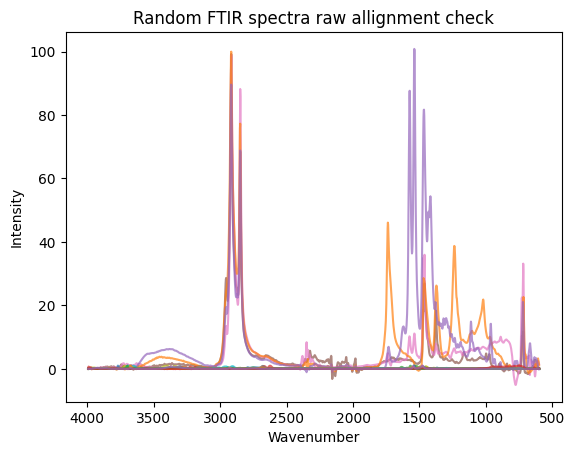

In [72]:
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)
n_plot = min(25, X.shape[0])
print(n_plot)
idx = rng.choice(X.shape[0], size=n_plot, replace=False)

plt.figure()
for i in idx:
    plt.plot(wn, X[i], alpha=0.7)

plt.gca().invert_xaxis()
plt.xlabel("Wavenumber")
plt.ylabel("Intensity")
plt.title("Random FTIR spectra raw allignment check")
plt.show()

Our spectras are unfortunetlaly clearly not alligned well. We have way too many spikes in itendity for some wavenumbers. Let's do **SNV normlaization** which for each spectrum for data will **subtract the mean** and then **divide by the std**.

In [74]:
import numpy as np

X = df[spec_cols].to_numpy(float)
mu = X.mean(axis=1, keepdims=True)
sd = X.std(axis=1, keepdims=True) + 1e-12
X_snv = (X - mu) / sd


df[spec_cols] = X_snv


#important, had a bug before as i was not overwriting thw new normalized X
X = df[spec_cols].to_numpy(float)

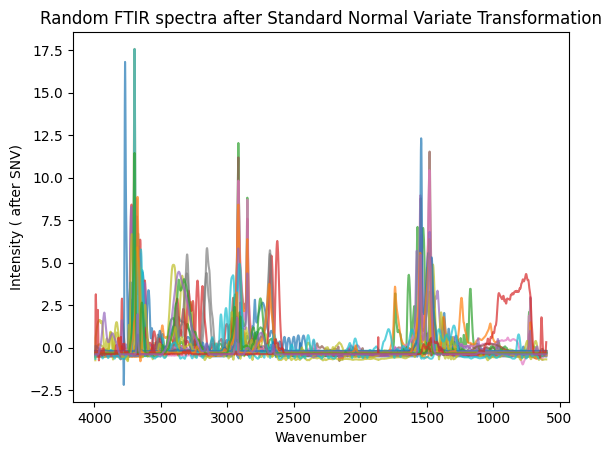

In [75]:
X_snv_now = df[spec_cols].to_numpy(float)

plt.figure()
for i in idx:
    plt.plot(wn, X_snv_now[i], alpha=0.7)

plt.gca().invert_xaxis()
plt.xlabel("Wavenumber")
plt.ylabel("Intensity ( after SNV)")
plt.title("Random FTIR spectra after Standard Normal Variate Transformation")
plt.show()

This looks much better now. The intensity scale on Y axis ranges now from -2.5 to 17.5 instead of from - aroud 0 to 100. Now let's also pick a label of material and see how 25 spectras allign for that. We should expect very good overlap between the 25 entires.

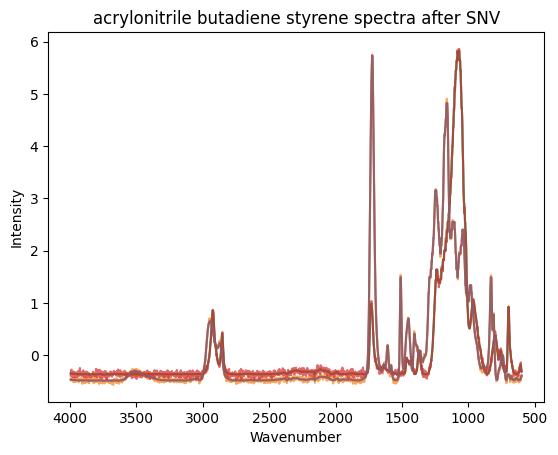

In [76]:
cls = "acrylonitrile butadiene styrene"
sub = df[df["framework"] == cls].sample(n=min(25, (df["framework"]==cls).sum()), random_state=0)

X_sub = sub[spec_cols].to_numpy(float)

plt.figure()
for i in range(X_sub.shape[0]):
    plt.plot(wn, X_sub[i], alpha=0.7)
plt.gca().invert_xaxis()
plt.title(f"{cls} spectra after SNV")
plt.xlabel("Wavenumber")
plt.ylabel("Intensity")
plt.show()


This looks quite good. Now let's do some PCA as we did in the binary classifier work and try to mantaian again around 90% - 95% of variance in the data explained by linear combinations of features.

We can clearly see that using only 19 PCs we can explain 95% of the variance from the full FTIR wavelengths available - 1.8 K. This means that we don’t need all 1.8K original wavelength features to describe how the spectra changes between samples – most of the is already captured by these 19 linear components.



---



This shows that the FTIR structure is clearly linear in the sense that a relatively small number of linear combinations of the original features (the principal components) can represent almost all of the variation in the data. So collumns in the wavelengths are highly correlated between themselves.


PCs for 95% variance: 92
PCs for 99% variance: 198


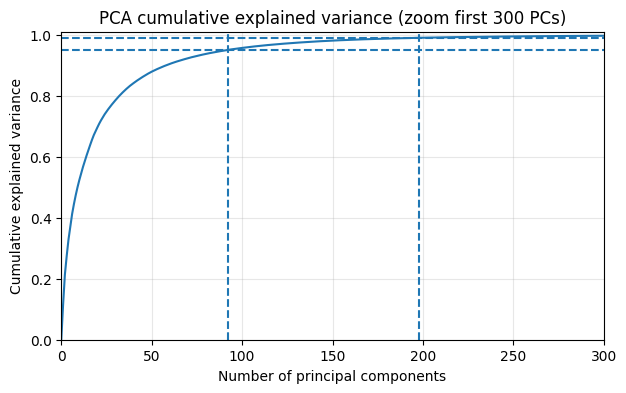

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X2 = StandardScaler().fit_transform(X)

max_comp = min(X2.shape[0] - 1, X2.shape[1])
pca = PCA(n_components=max_comp, random_state=0).fit(X2)
cum = np.cumsum(pca.explained_variance_ratio_)

n95 = np.searchsorted(cum, 0.95) + 1
n99 = np.searchsorted(cum, 0.99) + 1

print(f"PCs for 95% variance: {n95}")
print(f"PCs for 99% variance: {n99}")

zoom = 300

# x from 0..zoom, and cum starting with 0 at PC=0
x0 = np.arange(0, zoom + 1)
cum0 = np.r_[0.0, cum]   # length max_comp+1

plt.figure(figsize=(7,4))
plt.plot(x0, cum0[:zoom+1])  # <-- this includes (0,0)

plt.axhline(0.95, linestyle="--")
plt.axhline(0.99, linestyle="--")

if n95 <= zoom: plt.axvline(n95, linestyle="--")
if n99 <= zoom: plt.axvline(n99, linestyle="--")

plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title(f"PCA cumulative explained variance (zoom first {zoom} PCs)")
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.01)
plt.xlim(0, zoom)
plt.show()


# **Reducing the data to only 50 principal components**

As with 200 Principal components we can already explain most of the data (99%) we will reduce the numebr of original features to this 200 linear combinations between them. As we have enough data this time (at least in terms of samples) we are fine with using a larger number of "features", compared to our last work when we only used 20 to avoid overfitting as we did not had much data.




---


For example we can have PC1=a1​⋅x3992.6​+a2​⋅x3990.7​+⋯+a1863​⋅x401 being a linear combinatio of the initial features, which would explain the most variance.


After seeing the classes are unbalanced we decided to use **Stratified K Fold Cross validation** to mantain the distribution of labels in each fold.

https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/

This will improve generalization and would make the results more relaible.

"For example, if your original dataset had 80% Class 0 and 20% Class 1 your folds would reflect the same proportion of classes in your data. This creates improved and more reliable accuracy metrics."



In [82]:

print("Top 20 classes:")
print(df["framework"].value_counts().head(20))

print("\nBottom 20 classes:")
print(df["framework"].value_counts().tail(20))


Top 20 classes:
framework
polyethylene                  8242
polytehylene_terephthalate    6222
polystyrene                   3172
Poly(propylene)                729
Poly(ethylene)                 684
Poly(ethylene) + fouling       444
Cellulose acetate              210
Poly(styrene)                  198
Morphotype 1                   165
polyacrylonitrile              158
Ethylene propylene rubber      147
polycarbonates                 142
PEVA                           129
polymethacrylates               99
Poly(ethylene) like             75
polyamide                       69
fur                             69
Poly(amide)                     63
plant fibre                     54
polyester                       45
Name: count, dtype: int64

Bottom 20 classes:
framework
polyvinyl acetate                                      3
poly p-phenylene ether sulphone                        3
polyvinyl butyral                                      3
polyvinyl formal                               

In [83]:
import numpy as np
var_per_col = X.var(axis=0)
print("min var:", var_per_col.min())
print("max var:", var_per_col.max())
print("max/min ratio:", var_per_col.max() / (var_per_col.min() + 1e-12))

min var: 0.026832196987412318
max var: 10.28875491696082
max/min ratio: 383.448098618391


Based on this variance we enocuter per collumns even after each row was noamrlized with SVN, we will **process the collumn and simply normalize to have mean 0 and std 1 across features**.

# **Splitting data + PCA + K means clustering for trianing set**

We will use 3 folds as many classes have only 3 intances. This means that 1/3 from data will be used for validation.

# **PIPELINE**

For each fold from training we will:


1.   Scale the features for extra normalization as we've seen the values vary a lot.
2.   Create 50 PC based on lienar combiations of the original features
3.   Apply K means with a picked K based on best shiloutte score.
4.   Train models and validate on new unseen data - to avoid data leackage



In [84]:
y = df["framework"].astype(str).to_numpy()
X = df[spec_cols].to_numpy(float)


Now comes the idea of **clustering**... common in such spectra work. But our goal is to be able to label an input sequence of spectra FTIR data into a specific monomer.

Trining a different model for each cluster will produce overfitting espeically in some clusters where only a few very common classes end up.

To avoid this we will do somehting smarter and only cluster our training test (to improve generelization for unseen data) and we will create for each instance X features which are representing the distance of that feature from all X clusters.

This will basically add an aditional useful information to guide the model, besides the wavelengths.







Same Stratified K fold cross validation to mantain class distributions. Then, with inspiration from NLP and additional work we will use K means to cluster similar spectras and add DISTANCES FOR ALL CENTROIDS AS FEATURES to guide the model distinghuish a bit better between spectras. This extra features might prove to be very important for better results.

We are going to test the final model with and without this additional information encoded.


# **Shiloutte score for picking the best number of clusters.**

This is for the full dataset, we just use this as a test to find best K for clustering made on all availabe data

In [88]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score


Z = PCA(n_components=200, random_state=0).fit_transform(StandardScaler().fit_transform(X))


rng = np.random.default_rng(0)
sub_idx = rng.choice(Z.shape[0], size=min(10000, Z.shape[0]), replace=False)
Zsub = Z[sub_idx]

Ks = [4, 6, 8, 10, 12]
for k in Ks:
    km = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=2048, n_init=10)
    labels = km.fit_predict(Zsub)
    sil = silhouette_score(Zsub, labels)
    print(f"K={k:2d}  silhouette={sil:.4f}")

K= 4  silhouette=0.1373
K= 6  silhouette=0.1520
K= 8  silhouette=0.1291
K=10  silhouette=0.1452
K=12  silhouette=0.1346


K = 6 maximizes the silhoutte score.



---

For each data point (spectrum in PCA space), silhouette asks:


“Is this point closer to points in its own cluster than to points in the nearest other cluster?


It uses two distances:
a = average distance from the point to other points in its own cluster
(how tight/compact its cluster is for that point)
b = average distance from the point to points in the closest other cluster
(how far away the nearest competing cluster is)





s= (b-a) / max (a, b)

​
How to interpret s
s ≈ 1: great clustering. a is small, b is large → point is clearly in the right cluster.


s ≈ 0: point is on the boundary between clusters.


s < 0: point is closer to another cluster than its own → likely misclustered.

https://www.geeksforgeeks.org/machine-learning/what-is-silhouette-score/


For features intead of one hot encoding we will create a feature for each cluster to s**how the distance from the other ones**. This will help for better generalization than the standard one hot encoding and also helps for eexplinability and debugging.

# **DO NOT RUN THIS CELL PLEASE**
do not delete, do not modify. we will use this as a sample example of how data for training will look like

In [25]:
pc_cols = [f"PC{i+1}" for i in range(Z.shape[1])]
dist_cols = [f"dist_centroid_{j}" for j in range(dist.shape[1])]  # 4 distance features

feat_df = pd.DataFrame(
    np.hstack([Z, dist]),
    columns=pc_cols + dist_cols,
    index=df.index
)

feat_df["cluster_id"] = cluster_id

feat_df["framework"] = df["framework"].values
feat_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC47,PC48,PC49,PC50,dist_centroid_0,dist_centroid_1,dist_centroid_2,dist_centroid_3,cluster_id,framework
0,-10.507544,0.560029,0.553199,-0.245602,-2.262239,0.081884,0.370458,0.013187,0.823554,-0.922729,...,0.037940,0.047720,0.143349,-0.107221,3.413170,146.180811,16.827790,59.373911,0,polybutadiene
1,-10.355465,0.579007,0.519354,-0.128835,-2.325438,0.066259,0.307467,-0.055062,1.104572,-0.854123,...,0.008311,0.047904,0.098433,-0.085918,3.435806,146.017426,16.827285,59.250601,0,acrylonitrile butadiene styrene
2,-10.448573,0.571285,0.528399,-0.237693,-2.275718,0.056699,0.394304,0.013304,1.012128,-0.887252,...,0.000531,0.016851,0.094933,-0.108723,3.427466,146.119875,16.830391,59.322871,0,acrylonitrile butadiene styrene
3,-10.501380,0.580511,0.539138,-0.273992,-2.249015,0.068174,0.301288,-0.014892,0.954522,-0.885845,...,-0.000541,0.029786,0.105225,-0.104887,3.423830,146.170149,16.834362,59.376972,0,cellulose acetate
4,-10.530543,0.541138,0.525816,-0.325191,-2.254727,0.102757,0.329287,-0.005324,0.885129,-0.929092,...,-0.008659,0.039048,0.101298,-0.096083,3.421493,146.209517,16.835468,59.394384,0,acrylonitrile butadiene


In [89]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

folds = []
for fold_id, (train_idx, val_idx) in enumerate(cv.split(X, y), start=1):
    folds.append((train_idx, val_idx))
    print(f"Fold {fold_id}: train={len(train_idx)}, val={len(val_idx)}")


Fold 1: train=14532, val=7267
Fold 2: train=14533, val=7266
Fold 3: train=14533, val=7266


# **Now the pipeline**


Then we do PCA to the train set.

Then we do K-means for train set and our 200 PCA.

Then we compute distances for both tr and test set

Then we fit model and evaluate



In [101]:
import numpy as np
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import f1_score, balanced_accuracy_score

def cv_eval_model(model, X, y, folds, n_pc=200, k=6, random_state=0, scale_features=True):

    f1_macro_scores, f1_weighted_scores, bal_acc_scores = [], [], []

    for fold_id, (train_idx, val_idx) in enumerate(folds, start=1):
        X_tr_raw, X_va_raw = X[train_idx], X[val_idx]
        y_tr, y_va = y[train_idx], y[val_idx]

        # 1) PCA (train only)
        pca = PCA(n_components=n_pc, random_state=random_state)
        Z_tr = pca.fit_transform(X_tr_raw)
        Z_va = pca.transform(X_va_raw)

        # 2) KMeans (train only, PCA space)
        km = MiniBatchKMeans(n_clusters=k, random_state=random_state, batch_size=2048, n_init=10)
        km.fit(Z_tr)

        # 3) distance features
        dist_tr = km.transform(Z_tr)
        dist_va = km.transform(Z_va)

        # 4) final features
        X_tr_feat = np.hstack([Z_tr, dist_tr])
        X_va_feat = np.hstack([Z_va, dist_va])

        # 4b) OPTIONAL: scale final features (train only)
        if scale_features:
            feat_scaler = StandardScaler()
            X_tr_feat = feat_scaler.fit_transform(X_tr_feat)
            X_va_feat = feat_scaler.transform(X_va_feat)

        # 5) model
        m = clone(model)
        m.fit(X_tr_feat, y_tr)
        pred = m.predict(X_va_feat)

        # --- metrics ---
        f1_m = f1_score(y_va, pred, average="macro")
        f1_w = f1_score(y_va, pred, average="weighted")
        bal_acc = balanced_accuracy_score(y_va, pred)

        f1_macro_scores.append(f1_m)
        f1_weighted_scores.append(f1_w)
        bal_acc_scores.append(bal_acc)

        print(f"Fold {fold_id}: F1_macro={f1_m:.4f}  F1_weighted={f1_w:.4f}  BalancedAcc={bal_acc:.4f}")

    print("\n=== Averages ===")
    print(f"F1_macro:     {np.mean(f1_macro_scores):.4f}")
    print(f"F1_weighted:  {np.mean(f1_weighted_scores):.4f}")
    print(f"BalancedAcc:  {np.mean(bal_acc_scores):.4f}")

    return {
        "f1_macro": f1_macro_scores,
        "f1_weighted": f1_weighted_scores,
        "balanced_accuracy": bal_acc_scores,
    }


In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=0,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

svm_rbf_bal = SVC(
    kernel="rbf",
    C=10.0,
    gamma="scale",
    class_weight="balanced",
    probability=False,
    random_state=0
)

print("=== RandomForest ===")
cv_eval_model(rf, X, y, folds, n_pc=200, k=6, scale_features=False)

print("\n=== SVM (RBF) ===")
cv_eval_model(svm_rbf_bal, X, y, folds, n_pc=200, k=6, scale_features=True)


=== RandomForest ===
Fold 1: F1_macro=0.9870  F1_weighted=0.9876  BalancedAcc=0.9857
Fold 2: F1_macro=0.9665  F1_weighted=0.9840  BalancedAcc=0.9846
Fold 3: F1_macro=0.9750  F1_weighted=0.9829  BalancedAcc=0.9784

=== Averages ===
F1_macro:     0.9761
F1_weighted:  0.9848
BalancedAcc:  0.9829

=== SVM (RBF) ===
Fold 1: F1_macro=0.9834  F1_weighted=0.9593  BalancedAcc=0.9871
Fold 2: F1_macro=0.9834  F1_weighted=0.9576  BalancedAcc=0.9930
Fold 3: F1_macro=0.9869  F1_weighted=0.9599  BalancedAcc=0.9938

=== Averages ===
F1_macro:     0.9846
F1_weighted:  0.9589
BalancedAcc:  0.9913


{'f1_macro': [0.9834014564226975, 0.9834039118885314, 0.986939158782151],
 'f1_weighted': [0.9592773603162483, 0.9575827015106351, 0.9598550694810939],
 'balanced_accuracy': [np.float64(0.9871039611712147),
  np.float64(0.9929576475503784),
  np.float64(0.9938288851486418)]}

In [103]:
rng = np.random.default_rng(0)
y_shuf = rng.permutation(y)

print("=== RandomForest on SHUFFLED labels (should drop a lot) ===")
cv_eval_model(rf, X, y_shuf, folds, n_pc=200, k=6, scale_features=False)

=== RandomForest on SHUFFLED labels (should drop a lot) ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold 1: F1_macro=0.0091  F1_weighted=0.2657  BalancedAcc=0.0098


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold 2: F1_macro=0.0088  F1_weighted=0.2697  BalancedAcc=0.0098
Fold 3: F1_macro=0.0087  F1_weighted=0.2735  BalancedAcc=0.0101

=== Averages ===
F1_macro:     0.0089
F1_weighted:  0.2696
BalancedAcc:  0.0099


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


{'f1_macro': [0.009065660015545537,
  0.008804446059073262,
  0.008681115129262562],
 'f1_weighted': [0.2656567028809571, 0.2696593834607787, 0.27351232008241166],
 'balanced_accuracy': [np.float64(0.009750698009947257),
  np.float64(0.009820385837126246),
  np.float64(0.010061282174424074)]}